# Graph-based Recommendation Engine for Online Retail

Although recommendation engines are more often developed with different Machine Learning libraries for tabular data, we can also develop them using a graph-like structure. Using a graph data structure lets us easily traverse through the graph, and find patterns that nodes have in common.

The main problem with tabular data is that in order to traverse the relations, you need to merge/join tables/dataframes together. The joining process is computationally expensive and becomes slower as the number of joins increases, which makes real-time recommendations impractical in production. 

In this notebook, we will use the dataset that contains all purchases made for an online retail company based in the UK during eight months. This dataset could be found in [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+retail) or on [Kaggle](https://www.kaggle.com/vijayuv/onlineretail). This dataset contains information about each invoice that has been made in this period, and each invoice has information on which customer purchased which product, as well as the price, date, and quantity of the purchase. For this assignment, we will ignore some of these variables, and primarily focus on the customer, product, and quantity of the purchases.

The main idea is to create a graph that will have customers and products as nodes, and their relations as the graph edges.

The graph will be created so that all of the customers are connected to the products they have previously purchased. This kind of graph is called a **bipartite graph** and it contains only edges between nodes that belong to different categories. We will have customer nodes and product nodes, so we can only have customer-product relations, and not customer-customer or product-product relations. This will help us decide what are the most alike customers and what products should be recommended to a customer.


The recommendations will be made based on the most similar customers. This approach is called *User-based collaborative filtering* and it assumes that similar people will have similar tastes. Using relations between nodes, we will find users that have made the most similar purchases with the *active customer* (a customer to whom we want to recommend new products). This could be done in many different ways, but here we define similarity between users in two ways. One is only by looking at the number of products they have in common, and the other one is by calculating the difference based on the quantity of the products they have purchased. 

The methodology is as follows:
1. We create a graph in memory that contains all of the customers, products, and their relations from the dataset (or a fraction as mentioned later, to keep the example simple and less computationally demanding).
2. We define a customer we want to get recommendations for (active customer).
3. Then we create a subgraph containing only an active customer, products that active customer have previously purchased, and all customers that have at least one common purchased product with an active customer, as well as all other products that these customers have purchased in the past. 
4. After we create the subgraph, depending on the approach (using product degrees or relations weights), we further rank the products from the subgraph and select top K as the recommendation.

## Instalation and Loading Python Libraries

In [ ]:
!pip install -q pandas
!pip install -q numpy
!pip install -q networkx

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

## Dataset and Data Preparation

If the following url is unavailable, you can download data from [this url](https://www.kaggle.com/vijayuv/onlineretail) and upload the file *OnlineRetail.csv* manually.

In [ ]:
# Download data from the url of upload it manually
!wget -O OnlineRetail.xlsx http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx 

--2021-05-12 21:29:50--  http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘OnlineRetail.xlsx’

OnlineRetail.xlsx   100%[===================>]  22.62M  5.68MB/s    in 5.4s    

2021-05-12 21:29:56 (4.16 MB/s) - ‘OnlineRetail.xlsx’ saved [23715344/23715344]



In [ ]:
# Load data into dataframe

# If data is downloaded with wget
if 'OnlineRetail.xlsx' in os.listdir():
    retail_data_full = pd.read_excel('OnlineRetail.xlsx')
    display(retail_data_full.head())

# If data is uploaded manually
elif 'OnlineRetail.csv' in os.listdir():
    retail_data_full = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
    display(retail_data_full.head())

else:
    print('There is no file to load data from!')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


The dataset that we use contains around 500,000 rows. In this example, we are going to use a smaller sample (defined in the following cell), to have faster computations and better understand the results.

In [ ]:
retail_data = retail_data_full.sample(frac=0.05, random_state=1)

retail_data.shape

(27095, 8)

In [ ]:
# Remove rows without data and set appropriate types for columns
retail_data.dropna(subset=['StockCode', 'CustomerID'], inplace = True)
retail_data.CustomerID = retail_data.CustomerID.astype('int64')
retail_data.StockCode = retail_data.StockCode.astype(str)
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
94801,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom
455946,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom
403542,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom
471951,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany
380570,569823,23298,SPOTTY BUNTING,1,2011-10-06 12:15:00,4.95,16895,United Kingdom


In [ ]:
# Create a lookup table for stock descriptions
item_lookup = retail_data[['StockCode', 'Description']].dropna().drop_duplicates()

# Test for a product
item_lookup.loc[item_lookup.StockCode == '21977']

,StockCode,Description
364949,21977,PACK OF 60 PINK PAISLEY CAKE CASES


In [ ]:
# Remove unnecessary columns
retail_data = retail_data[['CustomerID', 'StockCode', 'Quantity']] 
retail_data.head()

,CustomerID,StockCode,Quantity
94801,13408,22960,-2
455946,13319,22952,48
403542,13509,20674,16
471951,12720,22556,12
380570,16895,23298,1


In [ ]:
# Create a dataframe that contains information about 
# the number of previous purchases
implicit_purchases = retail_data.groupby(['CustomerID', 'StockCode']).sum().reset_index() # Group together

# Replace a sum of zero purchases with a one to indicate purchased 
# This would have come as zero as the returns are recorded as negatives
implicit_purchases.Quantity.loc[implicit_purchases.Quantity <= 0] = 1 

# Show first few results
implicit_purchases.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,CustomerID,StockCode,Quantity
0,12347,21171,12
1,12347,22196,12
2,12347,22497,8
3,12347,22725,4
4,12347,22775,12


In [ ]:
implicit_purchases.Quantity.describe()

count    19380.000000
mean        12.921878
std         46.373193
min          1.000000
25%          2.000000
50%          5.000000
75%         12.000000
max       2100.000000
Name: Quantity, dtype: float64

Although we can keep the original Quantity variable for later similarity calculation, it might be better to ignore the high variance in the data and create categories. This way outliers (really high values for Quantity) will not create a huge impact in Euclidean distance (later used as the metrics for customer similarity).

We are going to transform the continuous variable *Quantity* into a new categorical variable *Quantity_cat*, where 1 represents a small number  and 4 a large number of purchased products.

In [ ]:
quantity_25 = implicit_purchases.Quantity.quantile(.25)
quantity_50 = implicit_purchases.Quantity.quantile(.50)
quantity_75 = implicit_purchases.Quantity.quantile(.75)
quantity_100 = implicit_purchases.Quantity.quantile(1)

bins = [0, quantity_25, quantity_50, quantity_75,quantity_100 ]
labels = [1,2,3,4]

implicit_purchases['Quantity_cat'] = pd.cut(implicit_purchases['Quantity'], bins=bins, labels=labels)
implicit_purchases.head()

,CustomerID,StockCode,Quantity,Quantity_cat
0,12347,21171,12,3
1,12347,22196,12,3
2,12347,22497,8,3
3,12347,22725,4,2
4,12347,22775,12,3


In [ ]:
implicit_purchases.Quantity_cat.value_counts()

1    6601
3    6212
4    3307
2    3260
Name: Quantity_cat, dtype: int64

Next, we will check the number of unique products and users in our dataset.

In [ ]:
# Create products list
products = sorted(implicit_purchases.StockCode.unique().tolist())

# Create customers list
customers = sorted(implicit_purchases.CustomerID.unique().tolist())

print('Number of unique products: {}'.format(len(products)))
print('Number of unique customers: {}'.format(len(customers)))

Number of unique products: 2694
Number of unique customers: 3280


## Creating a graph

As mentioned in the introduction, we will create a bipartite graph, containing two sets of nodes - Customers and Products. After we assign each node to its set, we will add weights to the graph. In this case, weights represent the quantity of the product a customer has bought in the past, where a customer is one node creating the edge, and the product is the other.

In [ ]:
# Creating a graph.
G = nx.Graph()

# Creating the Customer set of nodes and adding them to the graph
G.add_nodes_from(customers, bipartite = 'Customers' )

# Creating the Product set of nodes and adding them to the graph
G.add_nodes_from(products, bipartite = 'Products' )

# Adding edges among nodes
G.add_weighted_edges_from([(p, c, w) for p, c, w in zip(implicit_purchases.StockCode, implicit_purchases.CustomerID, implicit_purchases.Quantity_cat)])

# Show graph info
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 5974
Number of edges: 19380
Average degree:   6.4881


The number of connected components is 21


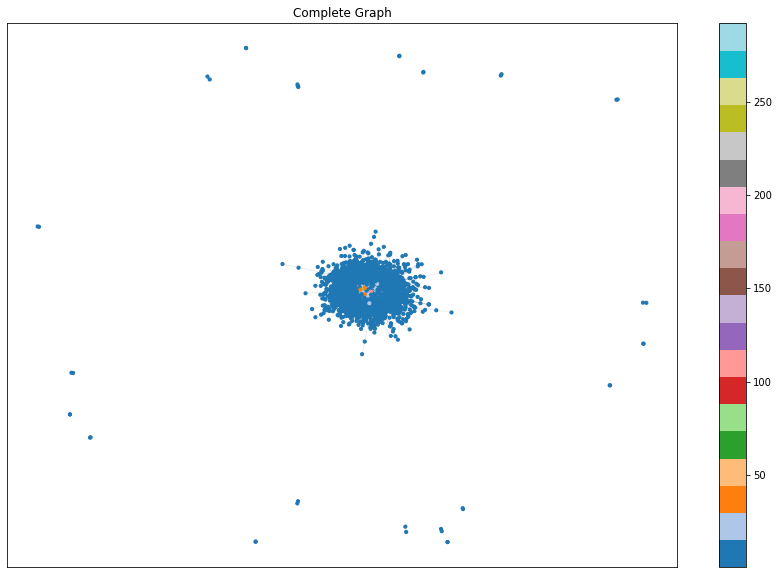

In [ ]:
# Draw graph

print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G)
fig=plt.figure(figsize=(15, 10))
labels = [G.degree(v) for v in G]
#betCent = nx.betweenness_centrality(G, normalized = True, endpoints = True)
node_size =  10
im=nx.draw_networkx_nodes(G, coords, node_size=node_size, node_color=labels, cmap='tab20')
nx.draw_networkx_edges(G, coords, alpha=0.1, width=0.7)
plt.title('Complete Graph')
plt.colorbar(im)

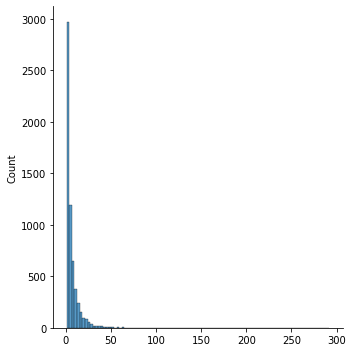

In [ ]:
sns.displot(labels, bins=100, )

From the distribution plot we can notice that most of the nodes have degree value smaller than 50, which is also seen in the graph above.

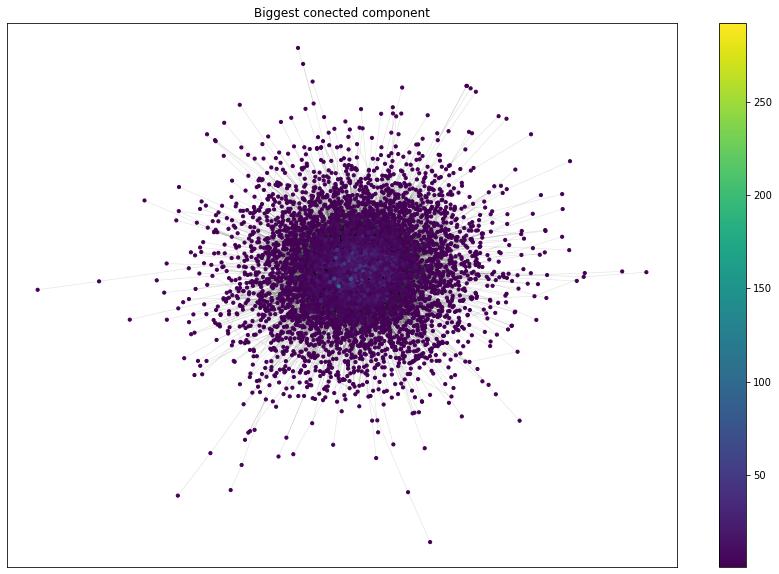

In [ ]:
# Largest connected component
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)

coords = nx.spring_layout(Gc) 
fig=plt.figure(figsize=(15, 10))
labels = [Gc.degree(v) for v in Gc]
#betCent = nx.betweenness_centrality(Gc, normalized = True, endpoints = True)
#node_size =  [v * 10000 for v in betCent.values()]
node_size = 10
im=nx.draw_networkx_nodes(Gc, coords, node_size=node_size, node_color=labels, cmap='viridis')
nx.draw_networkx_edges(Gc, coords, alpha=0.1, width=0.7)
plt.title('Biggest conected component')
plt.colorbar(im)

In [ ]:
# Show graph info
print(nx.info(Gc))

Name: 
Type: Graph
Number of nodes: 5933
Number of edges: 19359
Average degree:   6.5259


## User-based collaborative filtering


**User-based collaborative filtering** is a technique used in recommending that uses the similarity between customers to find the next best recommendation for a customer. By finding top k most similar customers, we lower the dimension of the graph (potential recommendations) and define the best recommendations from the set of products most similar customers previously purchased.

We are going to look at two different approaches to how graphs could be used for finding recommendations. The main difference is whether we consider weights or not. 

**The first approach** will disregard weights. We can consider all edges to have the same strength, and the only important thing is whether the edge exists or not. This means we will look at the products' *degrees* in the subgraph.

**The second approach** will consider weights from the graph (Note that weights in the graph are set based on the variable Quantity_cat which is a categorical variable that represents the level of frequency of the purchases). Using weights we can find most similar customers not only by counting similar purchases but looking at the exact weights for each customer-product relation. This way we can use Euclidean distance to find the most similar customers, and after that, use the same weights to find the most attractive products among the top k most similar customers.

We will test these two approaches for an arbitrary customer from the dataset.

In [ ]:
# Test for an arbitrary customer from the largest connected component
test_customer_id = -1

for n, d in Gc.nodes.items():
    if d['bipartite'] == 'Customers':
        test_customer_id = n
        break
print(f'Test customer id: {test_customer_id}')

Test customer id: 12347


### Approach using degree

First, we should define functions to retrieve first-degree and second-degree neighbors, and a function for creating a subgraph containing only top k most similar customers and all the products related to them.

In [ ]:
def get_first_neighbors(graph, node) -> list:
    """
    Returns a list of unique first neighbors for a given node in the graph.
    """
    return [first_neighbor for first_neighbor in graph.neighbors(node)]


def get_second_neighbors(graph, node) -> list:
    """
    Returns a list of unique second neighbors for a given node in the graph.
    """
    return [second_neighbor 
            for first_neighbor in graph.neighbors(node)
            for second_neighbor in graph.neighbors(first_neighbor) 
            if second_neighbor != node]

In [ ]:
def create_subgraph_for_customer_using_frequencies(graph, customer_id, k):
    ''' Creates a subgraph from the original graph containing 
    only a node itself, top k most similar users and products that
    any of them previously purchased.'''

    product_nodes = get_first_neighbors(graph, customer_id)
    second_neighbors = get_second_neighbors(graph, customer_id)

    # Create a list containing all first and second degree neighbours for a node
    nodes_neighb = [customer_id]
    nodes_neighb.extend(product_nodes)
    #nodes_neighb.extend(second_neighbors)

    # Select top k most frequent users
    Counter(second_neighbors)
    x = Counter(second_neighbors)
    top_k_most_common = [i[0] for i in x.most_common(k)]
    print('Top k most common users and number of mutual products: ')
    print(x.most_common(k))
    nodes_neighb.extend(top_k_most_common)

    potential_products = [products
                          for user in top_k_most_common
                          for products in get_first_neighbors(graph, user) 
                          ]
    potential_products = [product for product in potential_products if not graph.has_edge(customer_id, product)]
    nodes_neighb.extend(potential_products)

    return graph.subgraph(nodes_neighb)

Next, we will call the function for our graph and test customer.

In [ ]:
G_top_most_sim_freq = create_subgraph_for_customer_using_frequencies(G, test_customer_id, k=5)

Top k most common users and number of mutual products: 
[(14606, 2), (13098, 2), (14096, 2), (14911, 2), (17841, 2)]


(-1.0589765042066575,
 0.9177217811346055,
 -1.095672407746315,
 1.009120562672615)

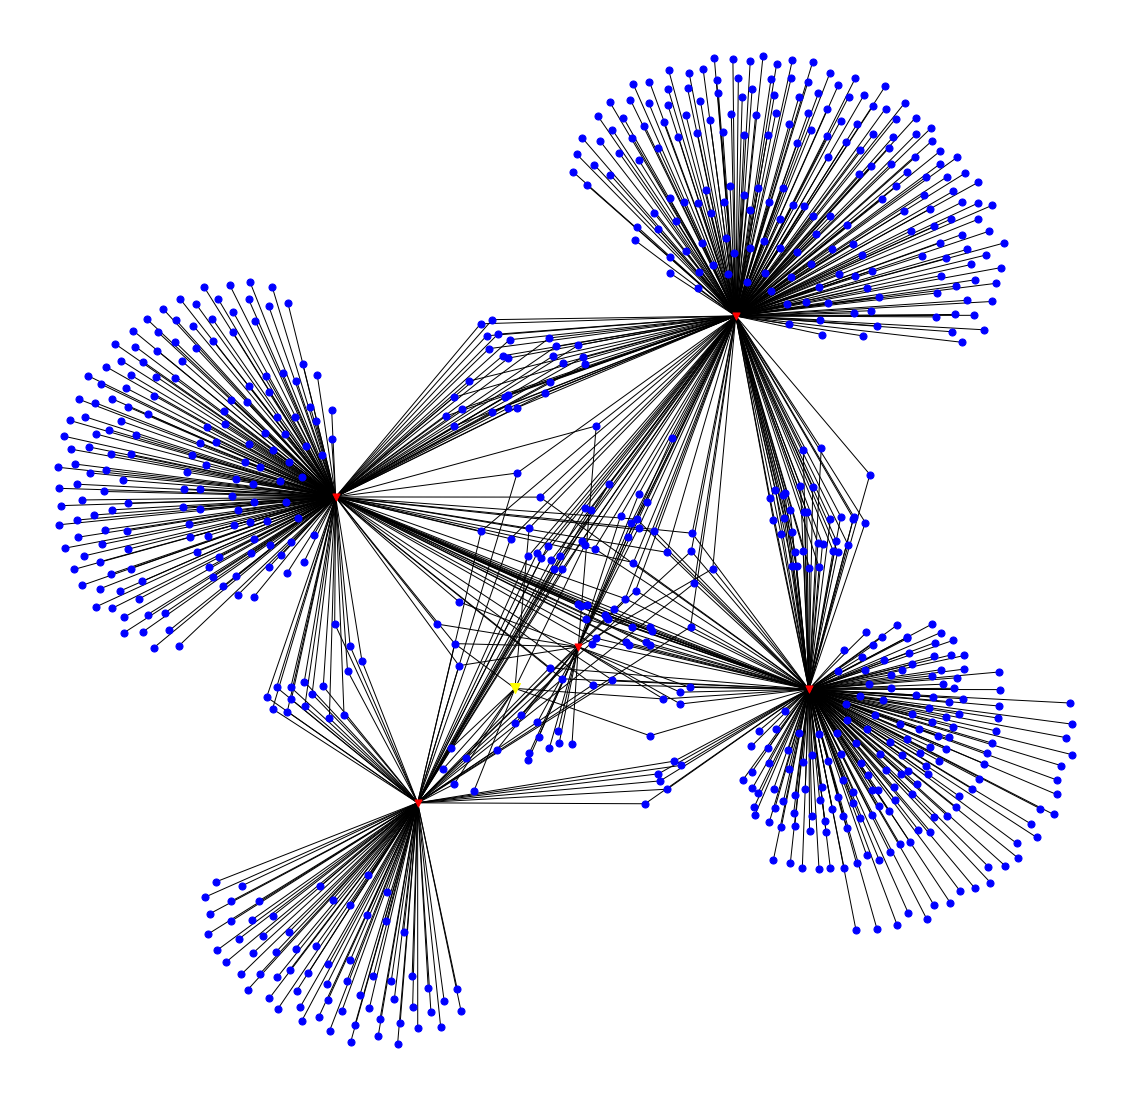

In [ ]:
# Draw graph

pos = nx.spring_layout(G_top_most_sim_freq)
plt.figure(figsize = (20, 20))

for bipartite, sign, color in zip(['Products', 'Customers'], ['o', 'v'], ['blue', 'red']):
    nx.draw_networkx_nodes(G_top_most_sim_freq, 
                           pos=pos, 
                           node_shape=sign, 
                           node_size=50, 
                           node_color=color, 
                           nodelist=[sNode[0] for sNode in filter(lambda x: x[1]['bipartite']==bipartite and x[0]!= test_customer_id, G_top_most_sim_freq.nodes.items())])
    
    if bipartite == 'Customers':    
        nx.draw_networkx_nodes(G_top_most_sim_freq, 
                              pos=pos, 
                              node_shape = sign, 
                              node_size=100, 
                              node_color='yellow', 
                              nodelist = [sNode[0] for sNode in filter(lambda x: x[0]==test_customer_id, G_top_most_sim_freq.nodes.items())])

nx.draw_networkx_edges(G_top_most_sim_freq, pos=pos)

plt.axis('off')

In the graph above we have the active customer colored in yellow, K most similar customer colored in red, and products are colored in blue.

The next step is to find the best match for a recommendation, based on how attractive the products from the graph above are to the top k most similar customers.

In [ ]:
# Extract only product nodes from the above graph and find nodes that have largest degree value
# Exclude products that are connected to the user that is being queried

common_nodes_f = [(n, G_top_most_sim_freq.degree(n)) for n, d in G_top_most_sim_freq.nodes(data=True) if d['bipartite']=='Products' and not G_top_most_sim_freq.has_edge(test_customer_id, n)]
top_nodes_f = sorted(common_nodes_f, key = lambda x: x[1], reverse=True)[:10]
top_nodes_f

[('84375', 4),
 ('23301', 3),
 ('23144', 3),
 ('22423', 3),
 ('20726', 3),
 ('20996', 3),
 ('21080', 3),
 ('22907', 3),
 ('22726', 3),
 ('85123A', 3)]

Let's show recommended products in green in the same graph as above:

(-1.0974970132112503,
 1.0474372774362564,
 -0.9807507127523423,
 0.9004152745008469)

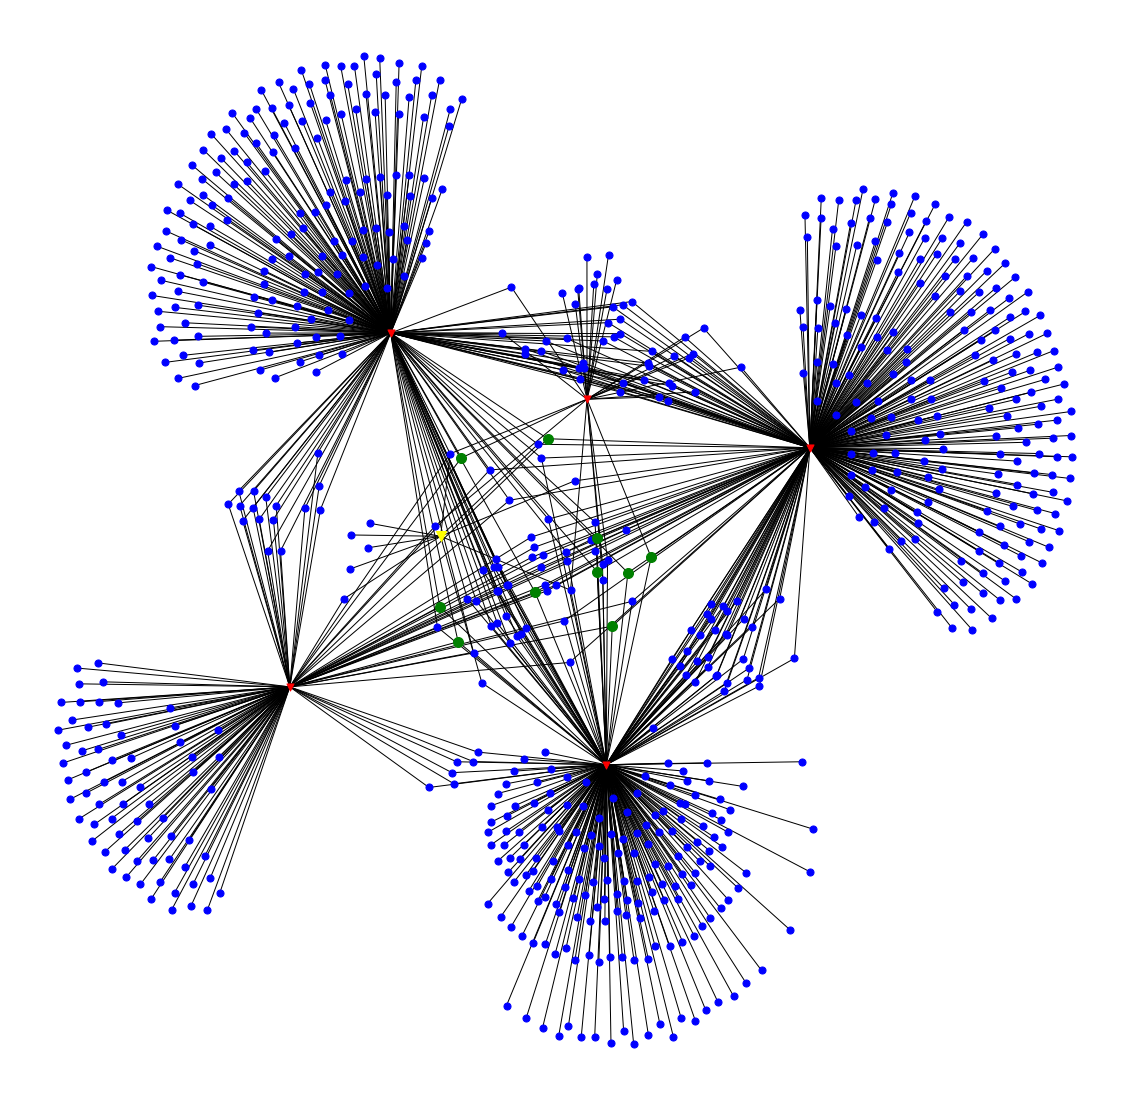

In [ ]:
# Draw graph

top_nodes = [n[0] for n in top_nodes_f]

pos = nx.spring_layout(G_top_most_sim_freq)
plt.figure(figsize = (20, 20))

# Draw nodes
for bipartite, sign, color in zip(['Products', 'Customers'], ['o', 'v'], ['blue', 'red']):
    nx.draw_networkx_nodes(G_top_most_sim_freq, 
                           pos=pos, 
                           node_shape=sign, 
                           node_size=50, 
                           node_color=color, 
                           nodelist=[sNode[0] for sNode in filter(lambda x: x[1]['bipartite']==bipartite 
                                                                            and x[0]!= test_customer_id
                                                                            and x[0] not in top_nodes,
                                                                  G_top_most_sim_freq.nodes.items())])
    
    nx.draw_networkx_nodes(G_top_most_sim_freq, 
                           pos=pos, 
                           node_shape=sign,
                           label=True,
                           node_size=100, 
                           node_color='green', 
                           nodelist=[sNode[0] for sNode in filter(lambda x: x[1]['bipartite']==bipartite 
                                                                            and x[0]!= test_customer_id
                                                                            and x[0] in top_nodes,
                                                                  G_top_most_sim_freq.nodes.items())])
    if bipartite == 'Customers':    
        nx.draw_networkx_nodes(G_top_most_sim_freq, 
                              pos=pos, 
                              node_shape = sign, 
                              node_size=100, 
                              node_color='yellow', 
                              nodelist = [sNode[0] for sNode in filter(lambda x: x[0]==test_customer_id, 
                                                                       G_top_most_sim_freq.nodes.items())])
        
                              
# Draw edges
nx.draw_networkx_edges(G_top_most_sim_freq, pos=pos)


## Print labels for top recommended product nodes
#nx.draw_networkx_labels(G_top_most_sim_freq.subgraph(top_nodes),
#                        pos, 
#                        font_size=14, 
#                        font_weight='bold', 
#                        horizontalalignment='left', )

plt.axis('off')

In [ ]:
# Show recommended items
print('Best recommendation items: ')
display(item_lookup.loc[item_lookup.StockCode.isin([x[0] for x in top_nodes_f])])

# Show previous purchases
print('\nItems that a customer has previously bought:')
display(item_lookup.loc[item_lookup.StockCode.isin([x for x in get_first_neighbors(G, test_customer_id)])])

Best recommendation items: 


,StockCode,Description
331683,22726,ALARM CLOCK BAKELIKE GREEN
476831,20996,JAZZ HEARTS ADDRESS BOOK
45939,84375,SET OF 20 KIDS COOKIE CUTTERS
421260,85123A,WHITE HANGING HEART T-LIGHT HOLDER
227973,20726,LUNCH BAG WOODLAND
263874,21080,SET/20 RED RETROSPOT PAPER NAPKINS
285231,22423,REGENCY CAKESTAND 3 TIER
499375,22907,PACK OF 20 NAPKINS PANTRY DESIGN
428802,23301,GARDENERS KNEELING PAD KEEP CALM
249001,23144,ZINC T-LIGHT HOLDER STARS SMALL



Items that a customer has previously bought:


,StockCode,Description
459193,23508,MINI PLAYING CARDS DOLLY GIRL
388661,23147,SINGLE ANTIQUE ROSE HOOK IVORY
446285,22196,SMALL HEART MEASURING SPOONS
462838,22725,ALARM CLOCK BAKELIKE CHOCOLATE
12501,84625A,PINK NEW BAROQUECANDLESTICK CANDLE
519829,23175,REGENCY MILK JUG PINK
266301,84997D,CHILDRENS CUTLERY POLKADOT PINK
14962,22497,SET OF 2 TINS VINTAGE BATHROOM
14946,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN
236423,21171,BATHROOM METAL SIGN


### Approach using weights 

Here, we will consider the similarity between users based on the weights of the edges. We will create vectors for each second-degree customer (a customer that had previously purchased at least one of the products that a customer we are looking at has purchased). These vectors show us the purchase score for each product (scores are in range 1-4, based on Quantity_cat variable), and then find Euclidean distance between these vectors and the original vector, which is a vector of weights for each product in the customer's product list. Elements in the test customer's vector must be greater than zero since we are sure the customer has previously purchased them, while zero value can appear in other customers' vectors, whenever a specific customer has not previously purchased a specific product.

We will again select the top k most similar customers, and create a graph based on them.

In [ ]:
def create_subgraph_for_customer_using_weights(graph, customer_id, k):
    ''' Creates a subgraph from the original graph containing 
    only a node itself, top k most similar users and products that
    any of them previously purchased.'''

    product_nodes = get_first_neighbors(graph, customer_id)
    second_neighbors = get_second_neighbors(graph, customer_id)

    neighbors_weights = {}

    for n in set(second_neighbors):
        for p in product_nodes:
            if n not in neighbors_weights:
                neighbors_weights[n]=[]
            if graph.has_edge(n, p):
                neighbors_weights[n].append(graph[n][p]['weight'])
            else:
                neighbors_weights[n].append(0)
    original_weights = [graph[customer_id][p]['weight'] for p in product_nodes]

    # Calculate Euclidean distance between customers
    distances = []
    for idx, weights in neighbors_weights.items() :  
        distance = np.linalg.norm(np.array(original_weights) - np.array(weights))
        distances.append((idx, distance)) 
    top_k_result = sorted(distances, key=lambda x: x[1], reverse=False)[:k]
    print('Top k most common users based on the euclidean distance with the test user: ')
    print(top_k_result)
    selected_customers = [x[0] for x in top_k_result]

    # Create a list containing all first and second degree neighbours for a node
    nodes_neighb = [customer_id]
    nodes_neighb.extend(product_nodes)
    nodes_neighb.extend(selected_customers)

    potential_products = [products
                         for user in selected_customers
                         for products in get_first_neighbors(graph, user) 
                         ]

    potential_products = [product for product in potential_products if not graph.has_edge(customer_id, product)]
    nodes_neighb.extend(potential_products)

    return graph.subgraph(nodes_neighb)

Test for the same customer as before.

In [ ]:
G_top_most_sim_weights = create_subgraph_for_customer_using_weights(G, test_customer_id, k=5)

Top k most common users based on the euclidean distance with the test user: 
[(12397, 8.831760866327848), (12985, 8.831760866327848), (15159, 8.831760866327848), (13269, 8.831760866327848), (17404, 8.831760866327848)]


(-0.9703723722989583,
 0.9906059339023818,
 -1.0969783072959167,
 1.0365444532142523)

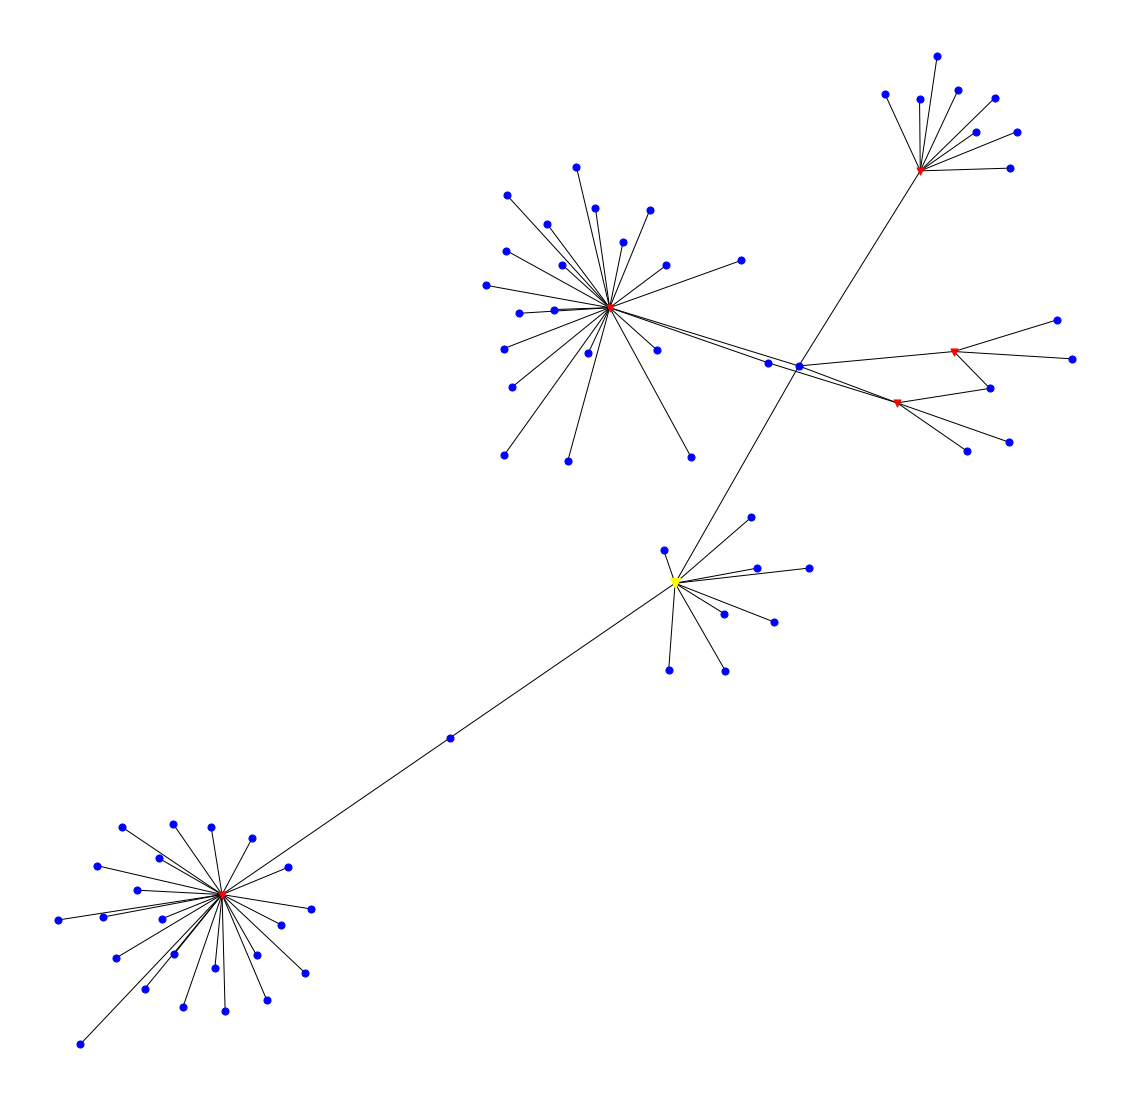

In [ ]:
# Draw graph

pos = nx.spring_layout(G_top_most_sim_weights)
plt.figure(figsize = (20, 20))

for bipartite, sign, color in zip(['Products', 'Customers'], ['o', 'v'], ['blue', 'red']):
    nx.draw_networkx_nodes(G_top_most_sim_weights, 
                           pos=pos, 
                           node_shape=sign, 
                           node_size=50, 
                           node_color=color, 
                           nodelist=[sNode[0] for sNode in filter(lambda x: x[1]['bipartite']==bipartite 
                                                                            and x[0]!= test_customer_id, 
                                                                  G_top_most_sim_weights.nodes.items())])
    if bipartite == 'Customers':
        nx.draw_networkx_nodes(G_top_most_sim_weights, 
                              pos=pos, 
                              node_shape = sign, 
                              node_size=100, 
                              node_color='yellow', 
                              nodelist = [sNode[0] for sNode in filter(lambda x: x[0]==test_customer_id,
                                                                       G_top_most_sim_weights.nodes.items())])

nx.draw_networkx_edges(G_top_most_sim_weights, pos=pos)

plt.axis('off')

When working with the weighted scenario, we will select products for a recommendation based on the total sum of weights products of the most similar users have. I.e. we will look at the products test customer has not previously purchased, but most similar customers have, and then find those that have the highest total sum of weights.

In [ ]:
def sum_weights_for_product(graph, product_id):
    '''Retrieves sum of weights for a specific product. It indicates
      how popular product is whithin the graph.'''

    neighbors = graph.neighbors(product_id)

    weights_sum = 0
    for n in neighbors:
        weights_sum += graph[n][product_id]['weight']
    return weights_sum

Next, to find the best recommendation we will use the function we defined, and apply it to the product nodes from the current graph. This way we will recommend those products that have the highest number of purchases among the most similar customers.

In [ ]:
# Extract only product nodes from the above graph and find nodes that have largest sum value
# Exclude products that are connected to the user that is being queried

common_nodes_w = [(n, sum_weights_for_product(G_top_most_sim_weights, n)) for n, d in G_top_most_sim_weights.nodes(data=True) if d['bipartite']=='Products' and not G_top_most_sim_weights.has_edge(test_customer_id, n)]
top_nodes_w = sorted(common_nodes_w, key = lambda x: x[1], reverse=True)[:10]
top_nodes_w

[('22530', 7),
 ('23480', 6),
 ('22045', 4),
 ('21238', 4),
 ('23295', 4),
 ('23307', 4),
 ('23084', 4),
 ('23285', 4),
 ('22465', 4),
 ('22417', 4)]

(-1.085496427127794, 0.7954249696836727, -0.488289248288694, 0.655736286648544)

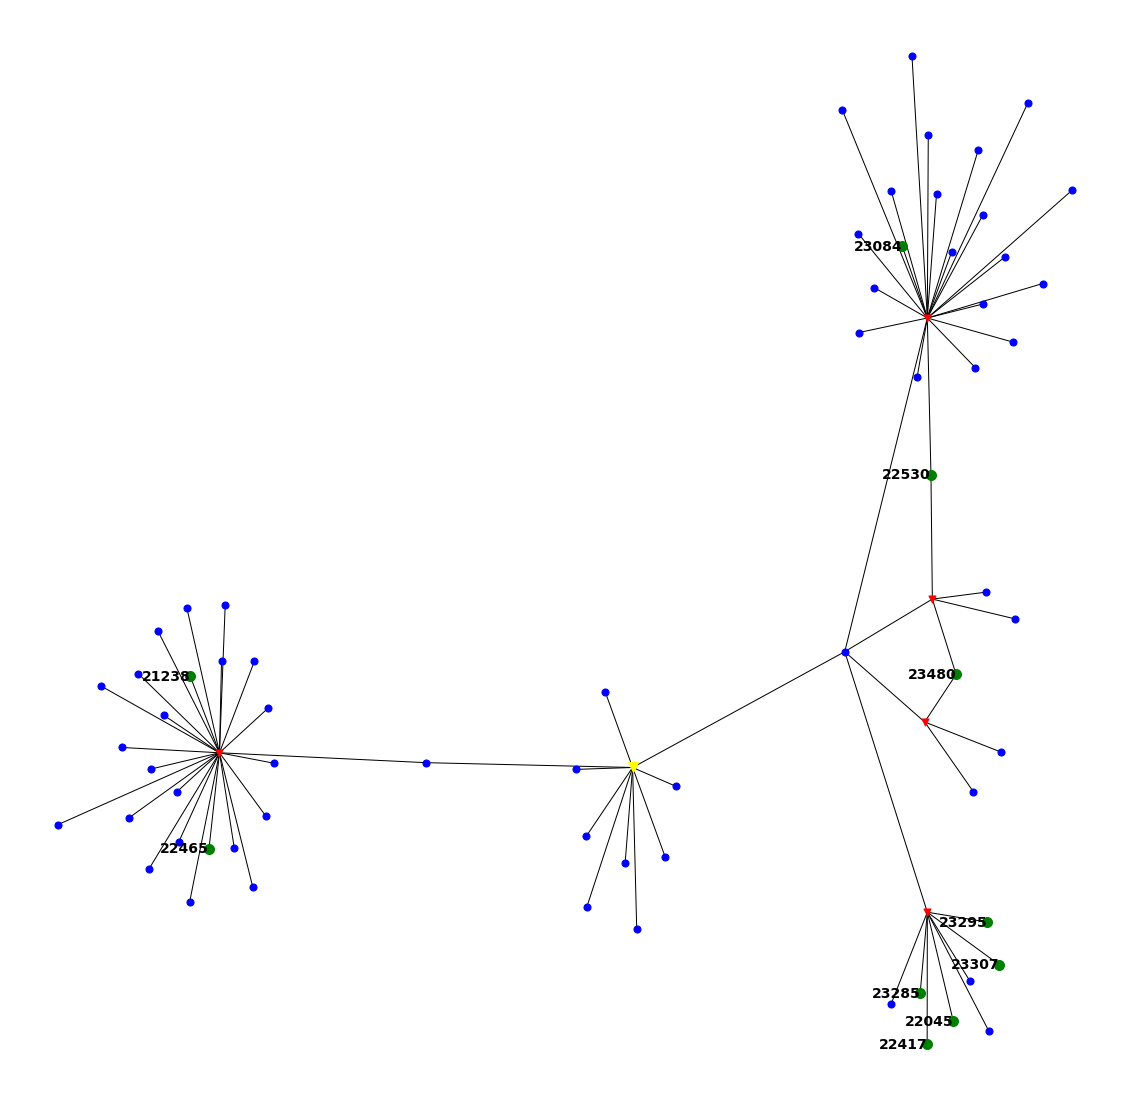

In [ ]:
# Draw graph

top_nodes = [n[0] for n in top_nodes_w]

pos = nx.spring_layout(G_top_most_sim_weights)
plt.figure(figsize = (20, 20))

# Draw nodes
for bipartite, sign, color in zip(['Products', 'Customers'], ['o', 'v'], ['blue', 'red']):
    nx.draw_networkx_nodes(G_top_most_sim_weights, 
                           pos=pos, 
                           node_shape=sign, 
                           node_size=50, 
                           node_color=color, 
                           nodelist=[sNode[0] for sNode in filter(lambda x: x[1]['bipartite']==bipartite 
                                                                            and x[0]!= test_customer_id
                                                                            and x[0] not in top_nodes,
                                                                  G_top_most_sim_weights.nodes.items())])
    
    nx.draw_networkx_nodes(G_top_most_sim_weights, 
                           pos=pos, 
                           node_shape=sign,
                           label=True,
                           node_size=100, 
                           node_color='green', 
                           nodelist=[sNode[0] for sNode in filter(lambda x: x[1]['bipartite']==bipartite 
                                                                            and x[0]!= test_customer_id
                                                                            and x[0] in top_nodes,
                                                                  G_top_most_sim_weights.nodes.items())])
    if bipartite == 'Customers':    
        nx.draw_networkx_nodes(G_top_most_sim_weights, 
                              pos=pos, 
                              node_shape = sign, 
                              node_size=100, 
                              node_color='yellow', 
                              nodelist = [sNode[0] for sNode in filter(lambda x: x[0]==test_customer_id, 
                                                                       G_top_most_sim_weights.nodes.items())])
        
                              
# Draw edges
nx.draw_networkx_edges(G_top_most_sim_weights, pos=pos)


# Print labels for top recommended product nodes
nx.draw_networkx_labels(G_top_most_sim_weights.subgraph(top_nodes),
                        pos, 
                        font_size=14, 
                        font_weight='bold', 
                        horizontalalignment='right', )

plt.axis('off')

In [ ]:
# Show recommended items
print('Best recommendation items: ')
display(item_lookup.loc[item_lookup.StockCode.isin([x[0] for x in top_nodes_w])])

# Show previous purchases
print('\nItems that a customer has previously bought:')
display(item_lookup.loc[item_lookup.StockCode.isin([x for x in get_first_neighbors(G, test_customer_id)])])

Best recommendation items: 


,StockCode,Description
242501,23307,SET OF 60 PANTRY DESIGN CAKE CASES
232754,23285,PINK VINTAGE SPOT BEAKER
333306,23295,SET OF 12 MINI LOAF BAKING CASES
505630,23084,RABBIT NIGHT LIGHT
3871,21238,RED RETROSPOT CUP
463169,22530,MAGIC DRAWING SLATE DOLLY GIRL
406103,22465,HANGING METAL STAR LANTERN
522500,22417,PACK OF 60 SPACEBOY CAKE CASES
305904,22045,SPACEBOY GIFT WRAP
446235,23480,MINI LIGHTS WOODLAND MUSHROOMS



Items that a customer has previously bought:


,StockCode,Description
459193,23508,MINI PLAYING CARDS DOLLY GIRL
388661,23147,SINGLE ANTIQUE ROSE HOOK IVORY
446285,22196,SMALL HEART MEASURING SPOONS
462838,22725,ALARM CLOCK BAKELIKE CHOCOLATE
12501,84625A,PINK NEW BAROQUECANDLESTICK CANDLE
519829,23175,REGENCY MILK JUG PINK
266301,84997D,CHILDRENS CUTLERY POLKADOT PINK
14962,22497,SET OF 2 TINS VINTAGE BATHROOM
14946,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN
236423,21171,BATHROOM METAL SIGN


## Results and conclusion

From the examples above we can see that the results differ significantly when using degree and weights approaches. It is important to notice that the results depend from case to case. Sometimes they might give us the same result, but sometimes they might not return any common item. No recommendation is correct, thus we cannot say that either one of these two approaches is better than the other. 

The advantage of both of these approaches is the computation speed and no need to train the model. Sometimes training the model can be a very long process when using some of the ML libraries and a lot of data, but with graphs, it is a real-time calculation based on current connections and the current state of the graph.

In this notebook, we presented two simple approaches that use a graph to generate recommendations. There are numerous ways to improve this recommender. Some of the things that could be further taken into consideration are a combined approach that uses both degree and the weights, or products that often go together.